In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lasio
import os

from statsmodels.tsa.arima.model import ARIMA
from sklearn.decomposition import PCA
from scipy.linalg import svd as SVD
from pywt import dwt
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding, LocallyLinearEmbedding, MDS
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow as tf
sys_info = tf.sysconfig.get_build_info()
print('Tensorflow built with CUDA?',  tf.test.is_built_with_cuda())
print('# GPU available:', len(tf.config.experimental.list_physical_devices('GPU')))
print("CUDA: {} | cuDNN: {}".format(sys_info["cuda_version"], sys_info["cudnn_version"]))
tf.config.list_physical_devices()

Tensorflow built with CUDA? True
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_data(LAS_folder, runs_file):
    ### Load Well Logs (LAS)
    df = {}
    count = 0
    for file in os.listdir(LAS_folder):
        if file.endswith('.las') or file.endswith('.LAS'):
            df[count] = lasio.read(os.path.join('log_data',file))
            count += 1

    ### Load all Mnemonics and Well Titles     
    mnemonics, well_title = {}, {}
    for i in range(len(df)):
        mnemonics[i] = list(df[i].curvesdict.keys())
        well_title[i] = list(df[i].well)

    ### Load Log Runs data
    well_runs_all = pd.read_excel(runs_file)
    well_runs = {}
    for i in range(len(df)):
        well_runs[i] = well_runs_all[well_runs_all['FILENAME'].astype('str')==df[i].header['Well']['API'].value+'00']

    ### Make DataFrames for each Well
    wdata = {}
    for i in range(len(df)):
        wdata[i] = pd.DataFrame(columns=mnemonics[i])
        for k in range(len(mnemonics[i])):
            wdata[i][mnemonics[i][k]] = np.nan_to_num(df[i][mnemonics[i][k]])

    return df, mnemonics, well_title, well_runs, wdata

In [4]:
def plot_k_suites(data, mnemo, k_start, k_end, figsize=(40,5), plot_mean=False):
    for k in range(k_start,k_end+1):
        plt.figure(figsize=figsize, facecolor='white')
        for p in range(1,len(mnemo[k])):
            plt.suptitle(str(k)+' | '+'Field='+data[k].well['FLD'].value+' | Name='+data[k].well['Well'].value+' | API='+data[k].well['API'].value)
            plt.subplot(1, len(mnemo[k]), p+1)
            plt.plot(data[k][mnemo[k][p]], data[k]['DEPT'], '.', markersize=2)
            plt.title(data[k].curvesdict[mnemo[k][p]].descr)
            plt.xlabel('{} [{}]'.format(data[k].curvesdict[mnemo[k][p]].mnemonic, data[k].curvesdict[mnemo[k][p]].unit))
            if plot_mean:
                plt.vlines(data[k][mnemo[k][p]][~np.isnan(data[k][mnemo[k][p]])].mean(), data[k]['DEPT'].min(), data[k]['DEPT'].max(), color='r')
            plt.gca().invert_yaxis(); plt.grid('on')
        plt.show()

In [5]:
def plot_well_and_runs(choose_well, df, well_runs, top_bottom=['TOPL_Fix','BOTL_Fix'], window=500, figsize=(10,5), bbox=(1.1,0.4)):
    mnem, mnem_keys = {}, df[choose_well].curvesdict.keys()
    for i in range(len(mnem_keys)):
        if list(mnem_keys)[i].startswith('GR'):
            mnem[i] = list(mnem_keys)[i]
    field = df[choose_well].header['Well']['FLD'].value
    well  = df[choose_well].header['Well']['WELL'].value.split()[0]
    api   = df[choose_well].header['Well']['API'].value
    roll_mean = pd.DataFrame(df[choose_well][list(mnem.values())[0]]).rolling(window, center=True).mean()
    plt.figure(figsize=figsize)
    for i in range(len(mnem)):
        plt.plot(df[choose_well]['DEPT'], df[choose_well][list(mnem.values())[i]], alpha=0.8, label=[list(mnem.values())[i]])
    plt.plot(df[choose_well]['DEPT'], roll_mean, c='k', label='Rolling Mean')
    for i in range(len(np.asarray(well_runs[choose_well][top_bottom[0]]).reshape(-1,1))):
        if not np.isnan(np.asarray(well_runs[choose_well][top_bottom[0]]).reshape(-1,1)[i]):
            plt.vlines(well_runs[choose_well][top_bottom[0]], 20, 100, colors='g', label='Run Top {}'.format(i))
            plt.vlines(well_runs[choose_well][top_bottom[1]], 20, 100, colors='r', label='Run Bot {}'.format(i))  
    plt.xlabel('DEPT'); plt.ylabel(list(mnem.values())[0][:2])
    plt.title('k: {} | Field: {} | Well: {} | API: {} | window: {}'.format(choose_well,field,well,api,window))
    plt.legend(loc='lower center', bbox_to_anchor=bbox); plt.grid('on')
    plt.show()

In [6]:
def plot_latent_projections(data, choose_well, zsvd, zpca, zdwt, figsize=(25,4)):
    field = data[choose_well].well['FLD'].value
    wname = data[choose_well].well['Well'].value.split()[0]
    api   = data[choose_well].well['API'].value
    plt.figure(figsize=figsize)
    plt.suptitle('#{} | {} , {} | API: {}'.format(choose_well, field, wname, api))
    plt.subplot(141)
    plt.plot(data[choose_well]['DEPT'], data[choose_well]['GR'])
    plt.xlabel('DEPT'); plt.ylabel('GR'); plt.grid(); plt.title('GR vs. Depth')
    plt.subplot(142)
    plt.scatter(zsvd[:,0], zsvd[:,1], s=1, alpha=0.5)
    plt.xlabel('$SVD_1$'); plt.ylabel('$SVD_2$'); plt.grid(); plt.title('SVD Projection')
    plt.subplot(143)
    plt.scatter(zpca[:,0], zpca[:,1], s=1, alpha=0.5)
    plt.xlabel('$PCA_1$'); plt.ylabel('$PCA_2$'); plt.grid(); plt.title('PCA Projection')
    plt.subplot(144)
    plt.scatter(zdwt[:,0], zdwt[:,1], s=1, alpha=0.5)
    plt.xlabel('$DWT_1$'); plt.ylabel('$DWTD_2$'); plt.grid(); plt.title('DWT Projection')
    plt.show()

def plot_normalized_latent_projections(data, choose_well, xdata, mnem, zsvd_n, zpca_n, zdwt_n, figsize=(25,4)):
    field = data[choose_well].well['FLD'].value
    wname = data[choose_well].well['Well'].value.split()[0]
    api   = data[choose_well].well['API'].value
    plt.figure(figsize=figsize)
    plt.suptitle('#{} | {} , {} | API: {}'.format(choose_well, field, wname, api))
    plt.subplot(141)
    plt.plot(xdata['DEPT'], xdata[mnem])
    plt.xlabel('DEPT'); plt.ylabel('GR'); plt.grid(); plt.title('GR vs. Depth')
    plt.subplot(142)
    plt.scatter(zsvd_n[:,0], zsvd_n[:,1], s=1, alpha=0.5)
    plt.xlabel('$SVD_1$'); plt.ylabel('$SVD_2$'); plt.grid(); plt.title('Normalized SVD Projection')
    plt.subplot(143)
    plt.scatter(zpca_n[:,0], zpca_n[:,1], s=1, alpha=0.5)
    plt.xlabel('$PCA_1$'); plt.ylabel('$PCA_2$'); plt.grid(); plt.title('Normalized PCA Projection')
    plt.subplot(144)
    plt.scatter(zdwt_n[:,0], zdwt_n[:,1], s=1, alpha=0.5)
    plt.xlabel('$DWT_1$'); plt.ylabel('$DWTD_2$'); plt.grid(); plt.title('normalized DWT Projection')
    plt.show()

In [7]:
def compute_latent_space(data, choose_well, wavelet='db1', dwtmode='per', normalize=False):
    if normalize:
        data_norm = pd.DataFrame(MinMaxScaler().fit_transform(data[choose_well]), columns=data[choose_well].columns)
        u0, s0, vt0 = SVD(data_norm, full_matrices=False)
        z_svd = u0[:,:2]@np.diag(s0)[:2,:2]@vt0[:2,:2]
        z_pca = PCA(2).fit_transform(data_norm)
        (cA, cD) = dwt(data_norm, wavelet=wavelet, mode=dwtmode)
        z_dwt = ((cA+cD)/2)[:,:2]
        return data_norm, z_svd, z_pca, z_dwt
    u0, s0, vt0 = SVD(data[choose_well], full_matrices=False)
    z_svd = u0[:,:2]@np.diag(s0)[:2,:2]@vt0[:2,:2]
    z_pca = PCA(2).fit_transform(data[choose_well])
    (cA,cD) = dwt(data[choose_well], wavelet=wavelet, mode=dwtmode)
    z_dwt   = ((cA+cD)/2)[:,:2]
    return z_svd, z_pca, z_dwt

***

In [8]:
df, mnemonics, well_title, well_runs, wdata = load_data('log_data', 'UT_MNEM_v2.xlsx')

choose_well = 17

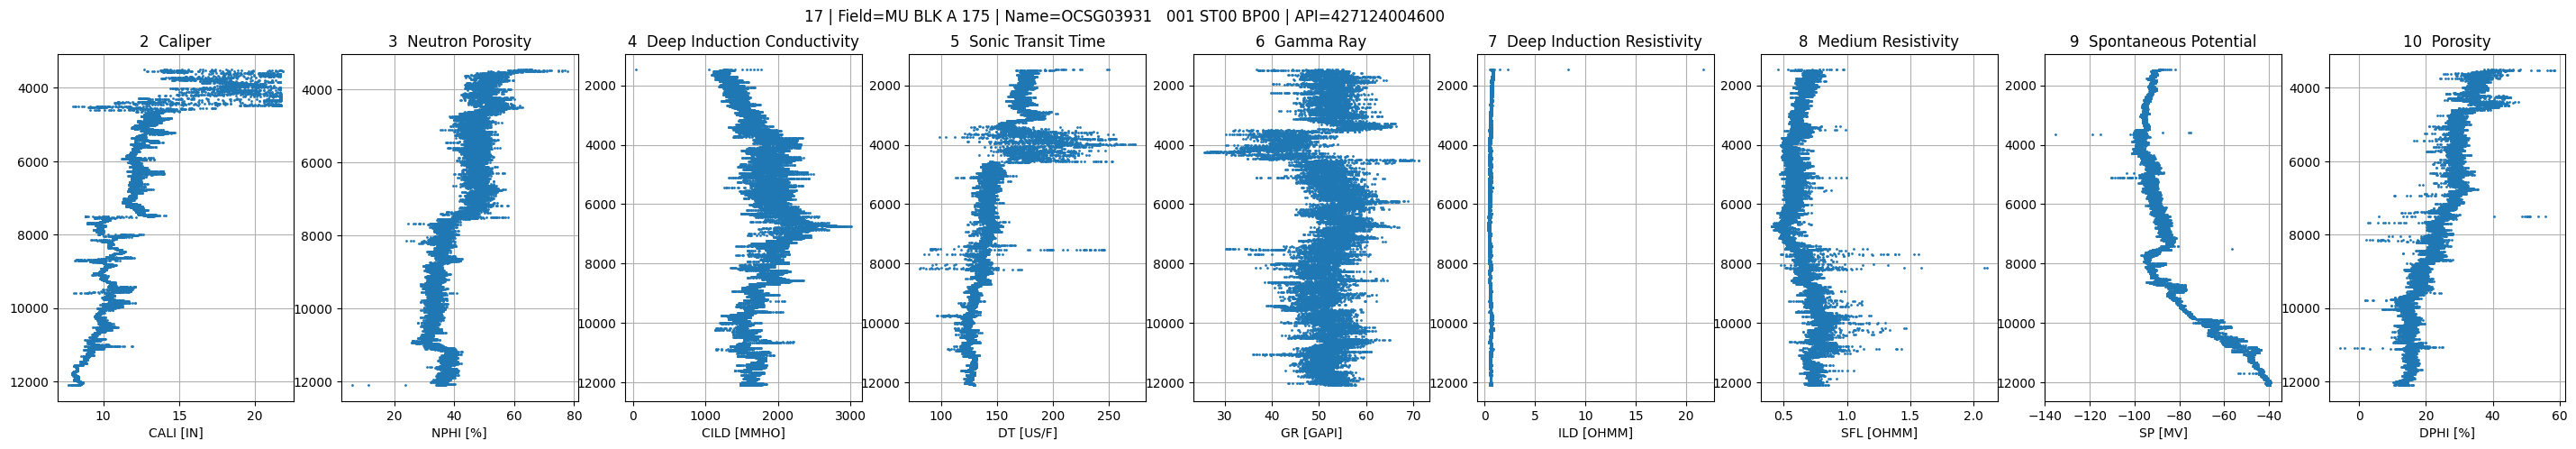

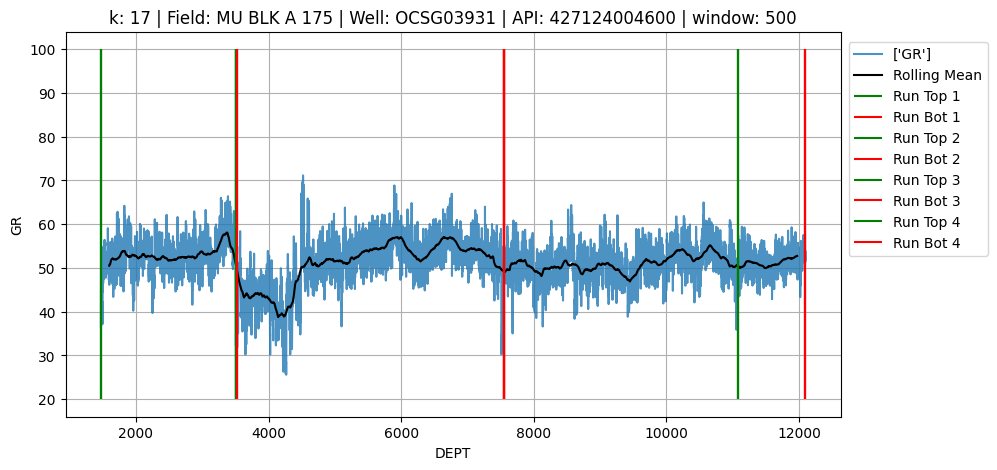

,DEPT,CALI,NPHI,CILD,DT,GR,ILD,SFL,SP,DPHI
0,1471.0,0.0,0.0,43.5076,207.1763,36.6747,21.6747,0.0000,-81.9652,0.0
1,1471.5,0.0,0.0,1051.4023,201.8521,40.2864,8.2761,0.0000,-83.7441,0.0
2,1472.0,0.0,0.0,1574.3125,202.4944,44.3405,2.3062,0.4555,-84.8408,0.0
3,1472.5,0.0,0.0,1619.4766,209.3799,47.1558,1.5124,0.5369,-85.6344,0.0
4,1473.0,0.0,0.0,1663.4160,210.9812,50.3577,1.0156,0.5923,-86.3281,0.0


In [9]:
plot_k_suites(df, mnemonics, k_start=choose_well, k_end=choose_well)
plot_well_and_runs(choose_well, df, well_runs)
wdata[choose_well].head()

Well #: 17


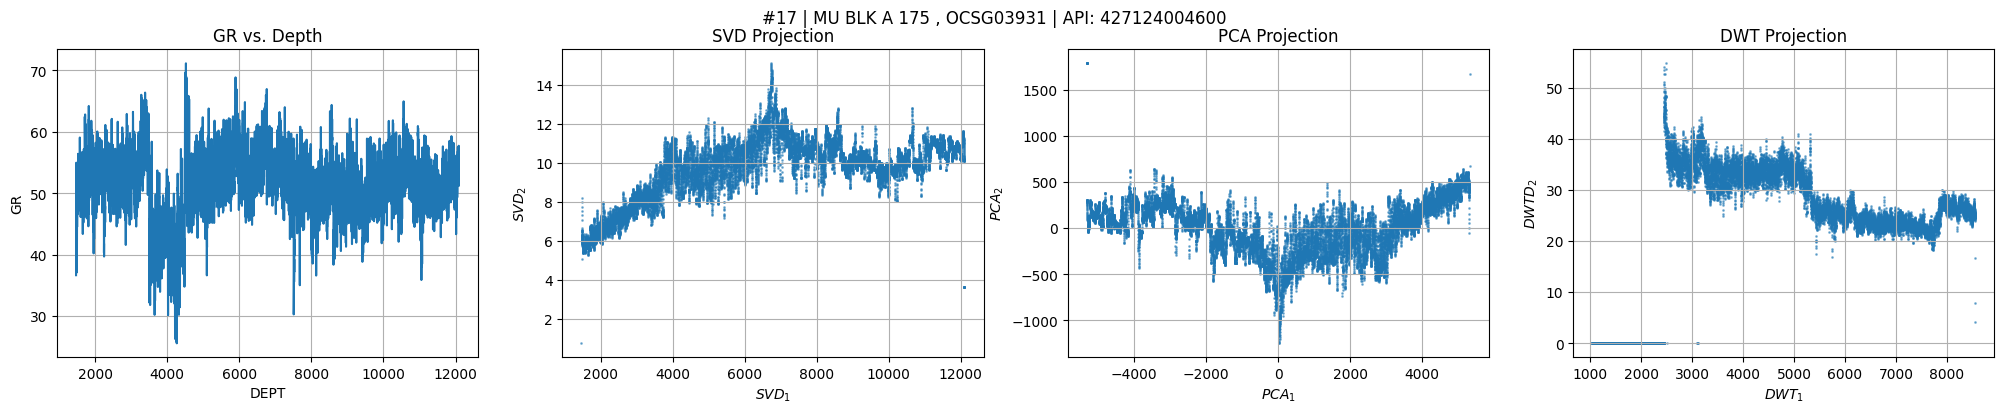

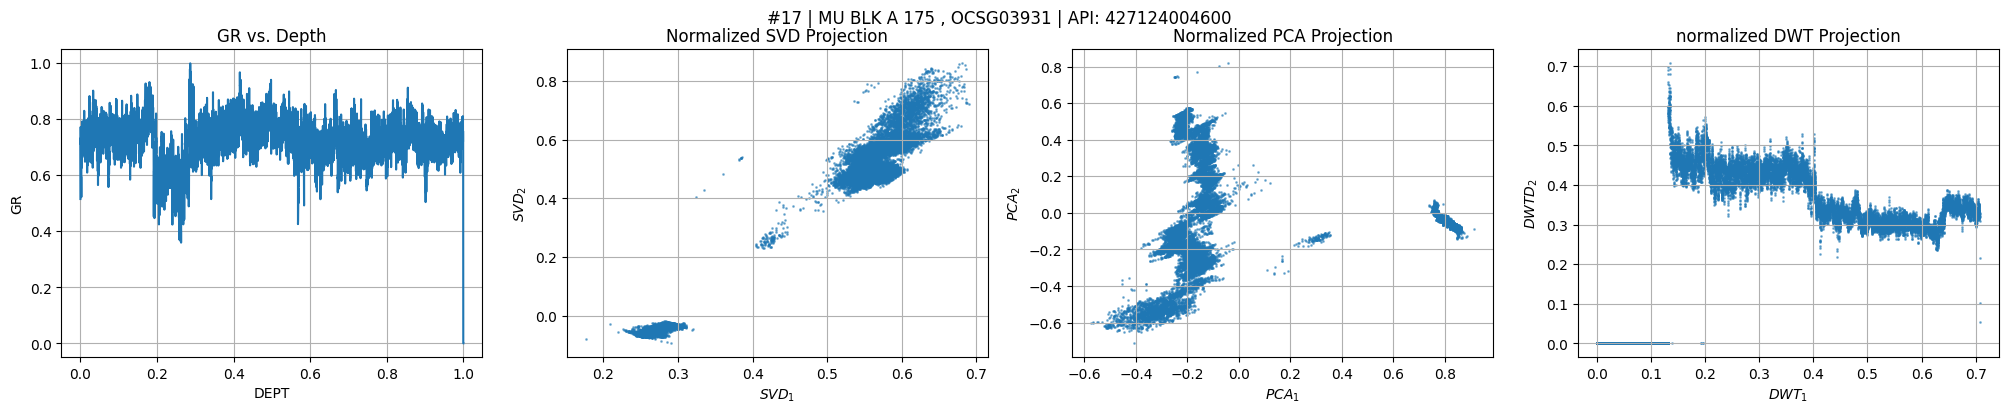

In [181]:
print('Well #: {}'.format(choose_well))

z_svd, z_pca, z_dwt = compute_latent_space(wdata, choose_well)
plot_latent_projections(df, choose_well, z_svd, z_pca, z_dwt)

### Repeat for normalized data
X_data, z_svd_n, z_pca_n, z_dwt_n = compute_latent_space(wdata, choose_well, normalize=True)
plot_normalized_latent_projections(df, choose_well, X_data, 'GR', z_svd_n, z_pca_n, z_dwt_n)

In [ ]:
# choose_well = 17

# X_data = pd.DataFrame(MinMaxScaler().fit_transform(wdata[choose_well]), columns=wdata[choose_well].columns)
# tsne = TSNE(n_components=2, init='random', learning_rate='auto', n_jobs=6).fit_transform(X_data)
# spectral = SpectralEmbedding().fit_transform(X_data)
# lle = LocallyLinearEmbedding().fit_transform(X_data)

# plt.figure(figsize=(30,4))
# plt.suptitle(df[choose_well].well['FLD'].value + ', ' + df[choose_well].well['Well'].value.split()[0] + ' | API=' + df[choose_well].well['API'].value)

# plt.subplot(141)
# plt.plot(wdata[k]['DEPT'], wdata[k]['GR'])
# plt.xlabel('DEPT'); plt.ylabel('GR'); plt.grid()
# plt.title('GR Log')

# plt.subplot(142)
# plt.scatter(tsne[:,0], tsne[:,1], s=1, alpha=0.5)
# plt.xlabel('$tsne_1$'); plt.ylabel('$tsne_2$'); plt.grid()
# plt.title('t-SNE')

# plt.subplot(143)
# plt.scatter(spectral[:,0], spectral[:,1], alpha=0.5)
# plt.xlabel('$spectral_1$'); plt.ylabel('$spectral_2$'); plt.grid()
# plt.title('Spectral Embedding')

# plt.subplot(144)
# plt.scatter(lle[:,0], lle[:,1], alpha=0.5)
# plt.xlabel('$lle_1$'); plt.ylabel('$lle_2$'); plt.grid()
# plt.title('Locally Linear Embedding')

# plt.show()

In [61]:
choose_well = 28
nclust = len(well_runs[choose_well])-1

X_data = pd.DataFrame(MinMaxScaler().fit_transform(wdata[choose_well]), columns=wdata[choose_well].columns)
full_labels = DBSCAN().fit_predict(X_data)
GR_only_labels = KMeans(n_clusters=3).fit_predict(np.array(X_data['GR']).reshape(-1,1))

z0 = PCA(n_components=2).fit_transform(X_data)
z_labels = AgglomerativeClustering(n_clusters=nclust).fit_predict(z0)

m0 = TSNE(n_components=2, init='random', learning_rate='auto', n_jobs=6).fit_transform(X_data)
m_labels = AgglomerativeClustering(n_clusters=nclust).fit_predict(m0)

API 427124011300


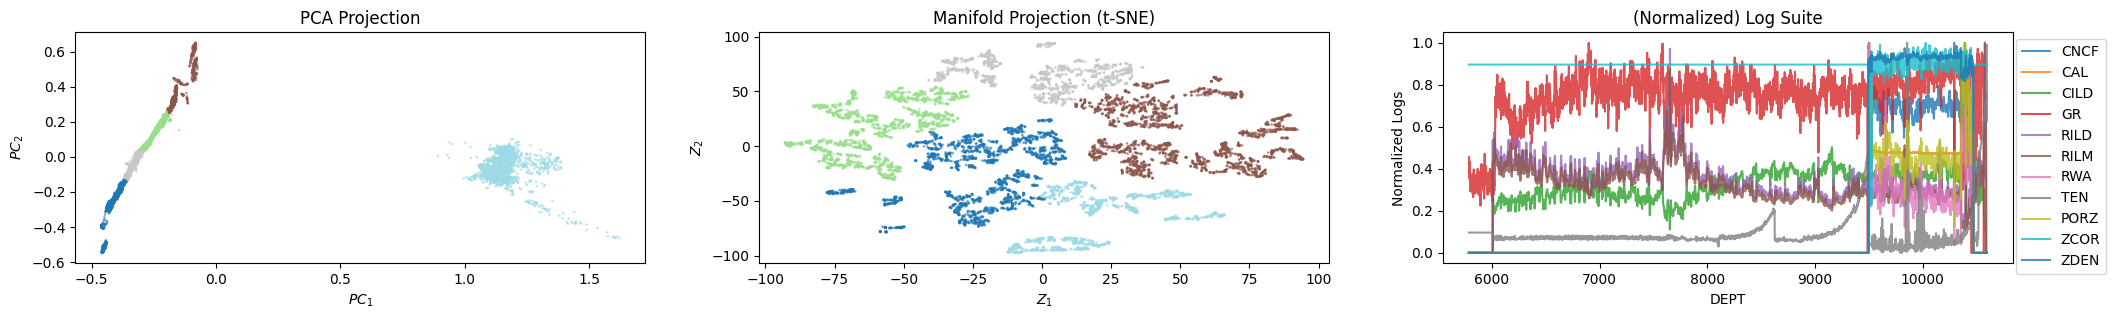

In [62]:
print('API', df[choose_well].header['Well']['API'].value)

plt.figure(figsize=(25,3))

plt.subplot(131)
plt.scatter(z0[:,0], z0[:,1], s=1, c=z_labels, alpha=0.5, cmap='tab20')
plt.xlabel('$PC_1$'); plt.ylabel('$PC_2$'); plt.title('PCA Projection')

plt.subplot(132)
plt.scatter(m0[:,0], m0[:,1], s=1, c=m_labels, alpha=0.5, cmap='tab20')
plt.xlabel('$Z_1$'); plt.ylabel('$Z_2$'); plt.title('Manifold Projection (t-SNE)')

plt.subplot(133)
plt.plot(wdata[choose_well]['DEPT'], X_data.iloc[:,1:], alpha=0.8)
plt.xlabel('DEPT'); plt.ylabel('Normalized Logs'); plt.title('(Normalized) Log Suite')
plt.legend(X_data.iloc[:,1:], loc='upper center', ncol=1, bbox_to_anchor=(1.085,1))

plt.show()

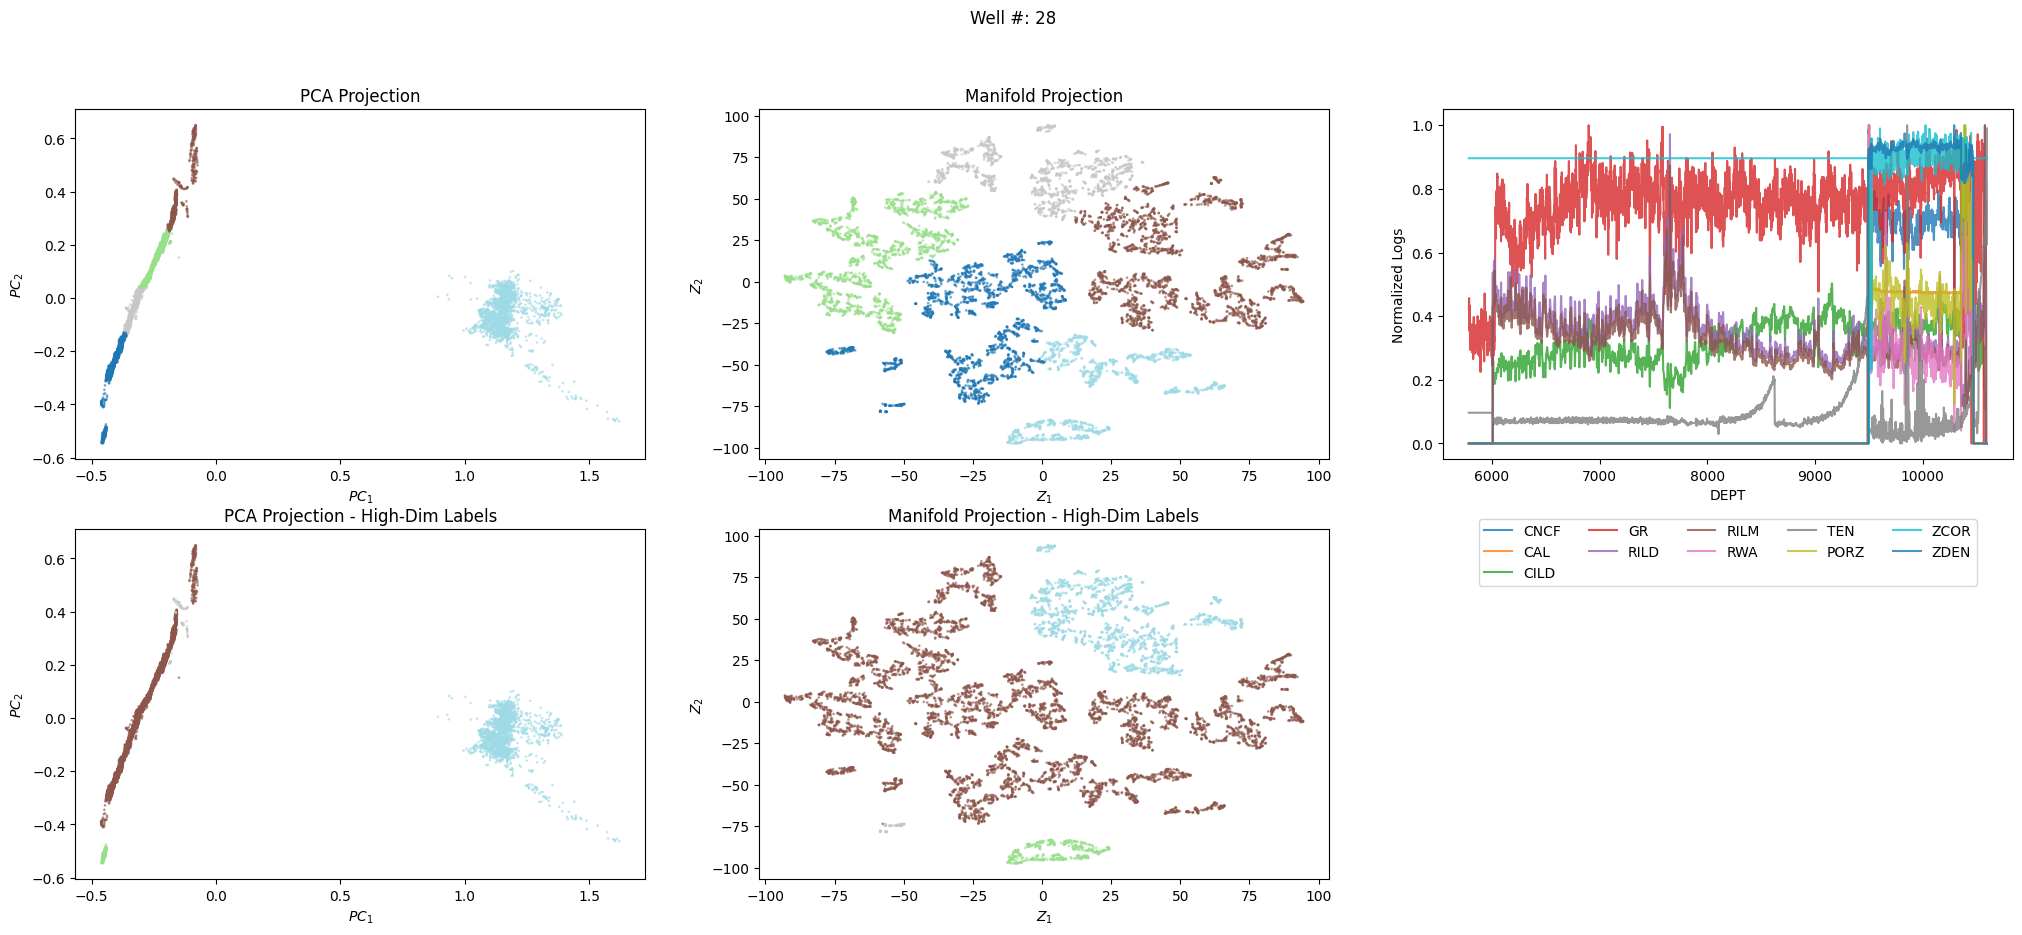

In [63]:
##### PLOTS #####
plt.figure(figsize=(25,10))
plt.suptitle('Well #: {}'.format(choose_well))

plt.subplot(231)
plt.scatter(z0[:,0], z0[:,1], s=1, c=z_labels, alpha=0.5, cmap='tab20')
plt.xlabel('$PC_1$'); plt.ylabel('$PC_2$'); plt.title('PCA Projection')

plt.subplot(232)
plt.scatter(m0[:,0], m0[:,1], s=1, c=m_labels, alpha=0.5, cmap='tab20')
plt.xlabel('$Z_1$'); plt.ylabel('$Z_2$'); plt.title('Manifold Projection')

plt.subplot(233)
plt.plot(wdata[choose_well]['DEPT'], X_data.iloc[:,1:], alpha=0.8)
plt.xlabel('DEPT'); plt.ylabel('Normalized Logs')
plt.legend(X_data.iloc[:,1:], loc='upper center', ncol=5, bbox_to_anchor=(0.5,-0.15))

plt.subplot(234)
plt.scatter(z0[:,0], z0[:,1], s=1, c=full_labels, alpha=0.5, cmap='tab20')
plt.xlabel('$PC_1$'); plt.ylabel('$PC_2$'); plt.title('PCA Projection - High-Dim Labels')

plt.subplot(235)
plt.scatter(m0[:,0], m0[:,1], s=1, c=full_labels, alpha=0.5, cmap='tab20')
plt.xlabel('$Z_1$'); plt.ylabel('$Z_2$'); plt.title('Manifold Projection - High-Dim Labels')

plt.show()

In [ ]:
titles = ['GR-only Clusters','High-Dim Clusters','PCA Clusters','Manifold Clusters']
labels = [GR_only_labels, full_labels, z_labels, m_labels]

fig, axs = plt.subplots(1, 5, figsize=(15,8), sharey=True)
plt.suptitle(df[choose_well].well['FLD'].value + ', ' + df[choose_well].well['Well'].value.split()[0] + ' | API=' + df[choose_well].well['API'].value)

axs[0].plot(wdata[choose_well]['GR'], wdata[choose_well]['DEPT'], alpha=0.8)
axs[0].set(ylabel='DEPT', title='GR vs. Depth')
axs[0].hlines(well_mnem[choose_well]['TOPL_Fix'], wdata[choose_well]['GR'].min(), np.ceil(wdata[choose_well]['GR'].max()), colors='g')
axs[0].hlines(well_mnem[choose_well]['BOTL_Fix'], wdata[choose_well]['GR'].min(), np.ceil(wdata[choose_well]['GR'].max()), colors='r')
for i in range(5):
    axs[i].set(xlabel='GR')
    axs[i].grid()
for k in range(4):
    axs[k+1].scatter(wdata[choose_well]['GR'], wdata[choose_well]['DEPT'], alpha=0.8, c=labels[k], s=1)
    axs[k+1].set(title=titles[k])
plt.gca().invert_yaxis()
plt.show()

# END